In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
warnings.filterwarnings("ignore")

# UDS data preprocess

In [2]:
# load uds dataset (baseline-first visit, subset features to ~90)
uds = pd.read_csv("../data/data_raw/investigator_uds_baseline.csv")
uds['datetime'] = pd.to_datetime(uds['datetime'])
print("UDS shape:  ", uds.shape)

# Load UDS dataset feature dictionary
uds_dict = pd.read_csv("../data/data_dictionary/uds_feature_dictionary_cleaned.csv")

UDS shape:   (45100, 94)


### Correct UDS Dataframe
Crosswalk Study conversion between neuropsychological testing variables from UDS 3.0 to 2.0

Convert new test results (i.e. MoCA, MINT) to the old test results (i.e. MMSE, BNT) using the conversion tables above
- Convert relevant new results, with corresponding index & column name

In [3]:
def correct_uds(uds):
    moca = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='MoCA2MMSE', na_values='NaN')
    mint = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='MINT2BNT')
    craft = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='Craft2Logic')
    numberFN = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='Number2DigitFN')
    numberFL = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='Number2DigitFL')
    numberBN = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='Number2DigitBN')
    numberBL = pd.read_excel('../data/data_raw/NACC Crosswalk Study Conversions.xlsx', sheet_name='Number2DigitBL')
    
    conv_mmse = pd.DataFrame([moca.iloc[x,1] if x < 31 else np.nan for x in 
            uds.iloc[(uds['NACCMMSE'] < 0).values]['MOCATOTS'].values], 
            index=uds.iloc[(uds['NACCMMSE'] < 0).values].index, columns=['NACCMMSE'])
    uds['NACCMMSE'].mask(uds['NACCMMSE'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_mmse)

    # MINT --> BNT 
    conv_bnt = pd.DataFrame([mint.iloc[x,1] if (x < 33 and x > -1) else np.nan for x in 
                uds.iloc[(uds['BOSTON'] < 0).values]['MINTTOTS'].values], 
                index=uds.iloc[(uds['BOSTON'] < 0).values].index, columns=['BOSTON'])
    uds['BOSTON'].mask(uds['BOSTON'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_bnt)

    # Craft Story 21 --> Logical Memory
    conv_logic = pd.DataFrame([craft.iloc[x,1] if x < 26 else np.nan for x in 
                    uds.iloc[(uds['MEMUNITS'] < 0).values]['CRAFTDRE'].values], 
                    index=uds.iloc[(uds['MEMUNITS'] < 0).values].index, columns=['MEMUNITS'])
    uds['MEMUNITS'].mask(uds['MEMUNITS'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_logic)

    # Number span, forward trials correct --> Digit span, number forward
    conv_numFN = pd.DataFrame([numberFN.iloc[x,1] if x < 15 else np.nan for x in 
                    uds.iloc[(uds['DIGIF'] < 0).values]['DIGFORCT'].values], 
                    index=uds.iloc[(uds['DIGIF'] < 0).values].index, columns=['DIGIF'])
    uds['DIGIF'].mask(uds['DIGIF'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_numFN)

    # Number span, forward length --> Digit span, length forward
    conv_numFL = pd.DataFrame([numberFL.iloc[x-3,1] if x < 10 and x > 2 else (x if x == 0 else np.nan)
                    for x in uds.iloc[(uds['DIGIFLEN'] < 0).values]['DIGFORSL'].values], 
                    index=uds.iloc[(uds['DIGIFLEN'] < 0).values].index, columns=['DIGIFLEN'])
    uds['DIGIFLEN'].mask(uds['DIGIFLEN'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_numFL)

    # Number span, backward trials correct --> Digit span, number backward
    conv_numBN = pd.DataFrame([numberBN.iloc[x,1] if x < 15 else np.nan for x in 
                    uds.iloc[(uds['DIGIB'] < 0).values]['DIGBACCT'].values], 
                    index=uds.iloc[(uds['DIGIB'] < 0).values].index, columns=['DIGIB'])
    uds['DIGIB'].mask(uds['DIGIB'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_numBN)

    # Number span, backward length --> Digit span, length backward
    conv_numBL = pd.DataFrame([numberBL.iloc[x-1,1] if x < 9 and x > 1 else (x if x == 0 else np.nan)
                    for x in uds.iloc[(uds['DIGIBLEN'] < 0).values]['DIGBACLS'].values], 
                    index=uds.iloc[(uds['DIGIBLEN'] < 0).values].index, columns=['DIGIBLEN'])
    uds['DIGIBLEN'].mask(uds['DIGIBLEN'] < 0, np.nan, inplace=True)
    uds = uds.fillna(conv_numBL)
    return uds

In [4]:
print("Original UDS Shape: ", uds.shape)
uds = correct_uds(uds)
print("After correction UDS Shape: ", uds.shape)

Original UDS Shape:  (45100, 94)
After correction UDS Shape:  (45100, 94)


### Mask UDS Missing
Check handbook for missing data encoding

UDS missing might due to multiple reasons:
 - EDUC: 99 (Unknown)
 - CDF: -4 (Not available)
 - GDS:  9 (Did not answer); -4 (Not available); 88 (Could not be calculated)
 - FAS, NPI: 99 (Unknown), -4 (Not available) 
 - NEURO: 95/995 (Physical problem), 96/9996 (Cognitive/behavior problem), 97/997 (Other problem), 98/998 (Verbal Refusal), 99 (Unknown), 88 (Score not calculated; missing at least one MMSE item), -4 (Not available), 

In [5]:
def mask_uds_na(df):
    uds['EDUC'] = uds['EDUC'].mask(uds['EDUC'] == 99, np.nan)
    for var in uds_dict[uds_dict['Category'] == 'CDF']['VariableName']:
        uds[var] = uds[var].mask(uds[var] == -4, np.nan)
    for var in uds_dict[uds_dict['Category'] == 'GDS']['VariableName']:
        if var != "NACCGDS":
            uds[var] = uds[var].mask(uds[var].isin([-4, 9]), np.nan)
        else:
            uds[var] = uds[var].mask(uds[var].isin([-4, 88]), np.nan)
    for var in uds_dict[uds_dict['Category'] == 'FAS']['VariableName']:
        uds[var] = uds[var].mask(uds[var].isin([8, 9, -4]), np.nan)
    for var in uds_dict[uds_dict['Category'] == 'NPI']['VariableName']:
        uds[var] = uds[var].mask(uds[var].isin([8, 9, -4]), np.nan)
    for var in uds_dict[uds_dict['Category'] == 'NEURO']['VariableName']:
        if var not in ['TRAILA', "TRAILB"]:
            uds[var] = uds[var].mask(uds[var].isin([88, 95, 96, 97, 98, 99, -4]), np.nan)
        else:
            uds[var] = uds[var].mask(uds[var].isin([995, 996, 997, 998, -4]), np.nan)
    return uds

def merge_missing_rate(df, df_dict):
    if "MissingRates" not in df_dict:
        tmp = df.isna().mean(axis=0).to_frame().reset_index()
        tmp.columns = ['VariableName', "MissingRates"]
        df_dict = df_dict.merge(tmp, on='VariableName', how='left')
    return df_dict

In [6]:
print("Before mapping, number of variables contained missing:  ", (uds.isna().sum()>0).sum())
uds = mask_uds_na(uds)
uds_dict = merge_missing_rate(uds, uds_dict)
uds_dict.to_csv("../data/data_dictionary/uds_feature_dictionary_cleaned.csv", index=False)
print("After mapping, number of variables contained missing:  ", (uds.isna().sum()>0).sum())

Before mapping, number of variables contained missing:   9
After mapping, number of variables contained missing:   78


### Encode Target variable
- NACCUDSD encodes: 1-Normal, 2-Impaired-not-MCI, 3-MCI, 4-Dementia
- NACCALZP: 1-2 AD-primary or contributuing, (3,7)-AD Non-contributing/CI but not AD, 8-Normal

Depending on the research goal, we consider the following two types of multi-class classification problems:
- 1. Normal, MCI-AD, Dementia-AD: three classification problems, both are AD related
- 2. Normal, MCI-AD, MCI-NonAD, Dementia-AD, Dementia-NonAD: Five-classification prblems for all types of MCI

Note we do not consider UDSD=2 cases. Patients are either nomal, MCI, or dementia. 

In [7]:
assert((uds[(uds['NACCUDSD'] == 1) & (uds['NACCALZP'] != 8)].shape[0] == 0) &
       (uds[(uds['NACCALZP'] == 8) & (uds['NACCUDSD'] != 1)].shape[0] == 0))
uds['NACCAD3'] = uds[['NACCUDSD', 'NACCALZP']].apply(
    lambda x: "Healthy" if x['NACCUDSD'] == 1 else 
              "MCI-AD" if (x['NACCUDSD'] == 3) & (x['NACCALZP'] in [1,2]) else
              "Dementia-AD" if (x['NACCUDSD'] == 4) & (x['NACCALZP'] in [1,2]) else
              np.nan, axis=1)
uds['NACCAD5'] = uds[['NACCUDSD', 'NACCALZP']].apply(
    lambda x: "Healthy" if x['NACCUDSD'] == 1 else 
              "MCI-AD" if (x['NACCUDSD'] == 3) & (x['NACCALZP'] in [1,2]) else
              "MCI-NonAD" if (x['NACCUDSD'] == 3) & (x['NACCALZP'] in [3, 7]) else
              "Dementia-AD" if (x['NACCUDSD'] == 4) & (x['NACCALZP'] in [1,2]) else
              "Dementia-NonAD" if (x['NACCUDSD'] == 4) & (x['NACCALZP'] in [3,7]) else
              np.nan, axis=1)
print("AD three classes number of people:  ", uds['NACCAD3'].dropna().shape)
print(Counter(uds['NACCAD3']),'\n')
print("AD Five classes number of people:  ", uds['NACCAD5'].dropna().shape)
print(Counter(uds['NACCAD5']),'\n')

uds.to_csv("../data/data_cleaned/uds.csv", index = False)
print("Saving UDS Successful...")

AD three classes number of people:   (34265,)
Counter({'Healthy': 17772, 'Dementia-AD': 12002, nan: 10835, 'MCI-AD': 4491}) 

AD Five classes number of people:   (43107,)
Counter({'Healthy': 17772, 'Dementia-AD': 12002, 'MCI-NonAD': 5361, 'MCI-AD': 4491, 'Dementia-NonAD': 3481, nan: 1993}) 

Saving UDS Successful...


# MRI Data Preprocess

In [8]:
# Load mri dataset, and remove couple features
mri_raw = pd.read_csv('../data/data_raw/investigator_mri_nacc57.csv')
mri_features_removed = ['NACCDICO','NACCNIFT','NACCMRFI','NACCNMRI','NACCMNUM','NACCMRSA','MRIMANU',
                    'MRIMODL','NACCMRIA', 'NACCMRDY', 'MRIT1', 'MRIT2', 'MRIDTI','MRIDWI', 'MRIFLAIR', 
                    'MRIOTHER', 'MRIFIELD', 'NACCMVOL', 'NACCADC']
mri = mri_raw.loc[:, ~mri_raw.columns.isin(mri_features_removed)] 
mri.rename(columns={'MRIYR': 'year', 'MRIMO': 'month', 'MRIDY': 'day'}, inplace=True)
mri['datetime'] = pd.to_datetime(mri[['year','month','day']],yearfirst=True,infer_datetime_format=True)
mri = mri.drop(['year','month','day'], axis=1)
print("MRI shape:  ", mri.shape)

mri_dict = pd.read_csv("../data/data_dictionary/mri_feature_dictionary_cleaned.csv")

MRI shape:   (11273, 170)


### Mask MRI Missing
Check handbook for missing data encoding
- MRI missing is all due to data not available / not applicable
- Discard patients having missing feature rate larger than 10%

In [9]:
def mask_mri_na(df):
    # MRI ROIs missing values (see Handbook)
    for code in [8.8888, 88.8888, 888.8888, 8888.888, 8888.8888,
                 9.999, 99.9999, 999.9999, 9999.999, 9999.9999]:
        df = df.mask(df == code, np.nan)
    return df

In [10]:
print("Before mapping, number of variables contained missing:  ", (mri.isna().sum()>0).sum())
mri = mask_mri_na(mri)
mri_dict = merge_missing_rate(mri, mri_dict)
mri_dict.to_csv("../data/data_dictionary/mri_feature_dictionary_cleaned.csv", index = False)
print("After mapping, number of variables contained missing:  ", (mri.isna().sum()>0).sum())

Before mapping, number of variables contained missing:   0
After mapping, number of variables contained missing:   167


In [11]:
print("(Missing Rate Threshold, Number of Patients)")
{round(r, 2): ((mri.isna().sum(axis=1) / 170) < r).sum() for r in np.arange(0.1, 1, 0.1)}

(Missing Rate Threshold, Number of Patients)


{0.1: 4588,
 0.2: 4589,
 0.3: 4589,
 0.4: 4589,
 0.5: 4589,
 0.6: 4589,
 0.7: 4590,
 0.8: 4590,
 0.9: 4590}

In [12]:
# Missing rate less than 10% (all 2873 patients are in UDS)
mri = mri[(mri.isna().sum(axis=1) / 170) < 0.1]
print("Number of unique patients:  ", mri['NACCID'].nunique())
print("MRI shape:  {} (all individuals having missing values less than 10%)".format(mri.shape))

Number of unique patients:   2873
MRI shape:  (4588, 170) (all individuals having missing values less than 10%)


### MRI Record Match with UDS Baseline
- Only keep MRI records within a year region of their base visit dates
- Previously each individual might have multiple MRI measurements. Here we only select the record that is cloest to the baseline visit (each NACCID corresponds to a unique measurement)

In [13]:
# Find MRI records within a year from UDS baseline visit
mri_uds_time = mri.merge(uds, on='NACCID', how='inner', suffixes=("_MRI", "_UDS"))[['NACCID','datetime_MRI', 'datetime_UDS']]
mri_uds_time['timediff'] = np.abs((mri_uds_time['datetime_MRI'] - mri_uds_time['datetime_UDS']).dt.days)
mri_uds_time = mri_uds_time.loc[mri_uds_time.groupby('NACCID')['timediff'].idxmin(),]
mri_uds_time['within-a-year'] =  (mri_uds_time['timediff'] < 365)
mri_uds_time.rename(columns={'datetime_MRI': 'datetime'}, inplace=True)
mri = mri.merge(mri_uds_time, on=['NACCID', 'datetime'], how='inner')
print("Number of overlap between UDS and MRI:  ", mri_uds_time.shape[0])
print("Number of patients tested MRI within a year from baseline:  ", mri_uds_time['within-a-year'].sum())
print("After preprocess, MRI shape:  ", mri.shape)

mri.to_csv("../data/data_cleaned/mri.csv", index = False)
print("MRI Saving Successful...")

Number of overlap between UDS and MRI:   2873
Number of patients tested MRI within a year from baseline:   1811
After preprocess, MRI shape:   (2873, 173)
MRI Saving Successful...


# CSF Data Preprocess
- Each patients might have several lumbar puncture results. We notice that under one lumbar puncture record, the patient might have ABeta, TTau, PTau assays at different dates. Thus, we use the CSFLP dates as the standard record time. We also take one ABeta, TTau, PTau result that is closet to the baseline visit (again, unde the same record, the assay dates might be different). As such, we have a unique CSF record for each patient. 

In [14]:
# Load csf data
csf = pd.read_csv("../data/data_raw/investigator_fcsf_nacc57.csv")
print("CSF shape:  ", csf.shape)

CSF shape:   (3017, 23)


In [15]:
csf.rename(columns={'CSFLPYR': 'year', 'CSFLPMO': 'month', 'CSFLPDY': 'day'}, inplace=True)
csf['datetime'] = pd.to_datetime(csf[['year','month','day']],yearfirst=True,infer_datetime_format=True)
csf = csf.drop(['month', 'day', 'year',
                'CSFABMO', 'CSFABDY', 'CSFABYR',
                'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 
                'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 
                'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
print("ABeta tested patient:  ", csf[~csf['CSFABETA'].isna()]['NACCID'].nunique())
print("PTau tested patient:  ", csf[~csf['CSFPTAU'].isna()]['NACCID'].nunique())
print("TTau tested patient:  ", csf[~csf['CSFTTAU'].isna()]['NACCID'].nunique())

ABeta tested patient:   2180
PTau tested patient:   1992
TTau tested patient:   2111


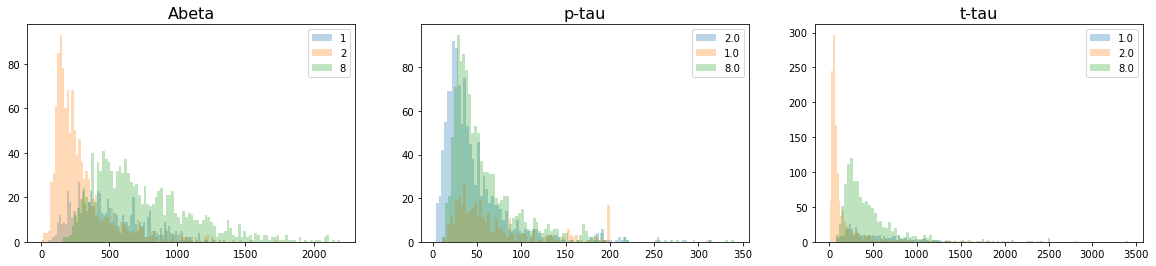

(3017, 4) (2719, 4) (2863, 4)


In [16]:
csfabeta = csf[['NACCID', 'datetime', 'CSFABETA', 'CSFABMD']].dropna(subset = ['CSFABETA'])
csfptau = csf[['NACCID', 'datetime',  'CSFPTAU','CSFPTMD']].dropna(subset = ['CSFPTAU'])
csfttau = csf[['NACCID', 'datetime', 'CSFTTAU', 'CSFTTMD']].dropna(subset = ['CSFTTAU'])
protein_name = ['Abeta', 'p-tau', 't-tau']
fig, axes = plt.subplots (1, 3, figsize = (20, 4))
for i, df in enumerate([csfabeta, csfptau, csfttau]):
    for assay_method in df.iloc[:,3].unique():
        axes[i].hist(df[df.iloc[:,3]==assay_method].iloc[:,2], bins=100, alpha=0.3, label = assay_method)
    axes[i].legend()
    axes[i].set_title(protein_name[i], fontsize = 16)
plt.show()
print(csfabeta.shape, csfptau.shape, csfttau.shape)

In [17]:
csfabeta_merged = csfabeta.merge(uds[['NACCID', 'datetime']], on=['NACCID'], suffixes=("_csf", "_uds"), how='inner')
csfabeta_merged['time_diff'] = np.abs((csfabeta_merged['datetime_csf'] - csfabeta_merged['datetime_uds']).dt.days)
csfabeta_merged = csfabeta_merged.loc[csfabeta_merged.groupby('NACCID')['time_diff'].idxmin(), ]
print("ABeta tested patient:  ", csfabeta_merged.shape)

csfttau_merged = csfttau.merge(uds[['NACCID', 'datetime']], on=['NACCID'], suffixes=("_csf", "_uds"), how='inner')
csfttau_merged['time_diff'] = np.abs((csfttau_merged['datetime_csf'] - csfttau_merged['datetime_uds']).dt.days)
csfttau_merged = csfttau_merged.loc[csfttau_merged.groupby('NACCID')['time_diff'].idxmin(), ]
print("PTau tested patient:  ", csfttau_merged.shape)

csfptau_merged = csfptau.merge(uds[['NACCID', 'datetime']], on=['NACCID'], suffixes=("_csf", "_uds"), how='inner')
csfptau_merged['time_diff'] = np.abs((csfptau_merged['datetime_csf'] - csfptau_merged['datetime_uds']).dt.days)
csfptau_merged = csfptau_merged.loc[csfptau_merged.groupby('NACCID')['time_diff'].idxmin(), ]
print("TTau tested patient:  ", csfptau_merged.shape)

csf_merged = csfabeta_merged[['NACCID', 'CSFABETA', 'CSFABMD']].merge(
    csfttau_merged[['NACCID', 'CSFTTAU', 'CSFTTMD']], on="NACCID", how='outer')
csf_merged = csf_merged.merge(csfptau_merged[['NACCID', 'CSFPTAU', 'CSFPTMD']], on="NACCID", how='outer')

print("Merged shape: ", csf_merged.shape)

csf_merged.to_csv("../data/data_cleaned/csf.csv", index = False)
print("CSF Saving Successful...")

ABeta tested patient:   (2180, 6)
PTau tested patient:   (2111, 6)
TTau tested patient:   (1992, 6)
Merged shape:  (2180, 7)
CSF Saving Successful...


In [18]:
# csfabeta = csf[['NACCID', 'CSFLPMO', 'CSFLPDY', 'CSFLPYR', 'CSFABETA', 'CSFABMO', 'CSFABDY', 'CSFABYR' , 'CSFABMD', 'CSFABMDX']]
# csfptau = csf[['NACCID', 'CSFLPMO', 'CSFLPDY', 'CSFLPYR', 'CSFPTAU', 'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFPTMD', 'CSFPTMDX']]
# csfttau = csf[['NACCID', 'CSFLPMO', 'CSFLPDY', 'CSFLPYR', 'CSFTTAU',  'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFTTMD', 'CSFTTMDX']]